In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("ticks")
sns.set_context(context="talk")

## READ DATA IN FROM GOOGLE DOCS ##
# see http://gspread.readthedocs.io/en/latest/oauth2.html
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/urai/Documents/stuff/IBL-CSHL-citricAcid-dc4fee22cc42.json', scope)
gc = gspread.authorize(credentials)

# now read the doc
doc = gc.open_by_key('1Ne466FpvhqbMQIfuivZRhp_3alBVTgPGSMc0q387frk')

In [2]:
# READ ALL WORKSHEETS WITH THE ANNE & VAL'S MOUSE DATA
worksheet_list = [
    {"sheet": "Batch1", "baseline": "free hydrogel", "intervention": "citric acid water"},
    {"sheet": "Batch2", "baseline": "water restriction", "intervention": "citric acid water"},
    {"sheet": "Batch3", "baseline": "free hydrogel", "intervention": "citric acid hydrogel"},
    {"sheet": "Batch4", "baseline": "water restriction", "intervention": "citric acid hydrogel"},
    {"sheet": "Batch5", "baseline": "citric acid water", "intervention": "citric acid hydrogel"}]

results = []
for w, entry in enumerate(worksheet_list):
    worksheet = doc.worksheet(entry["sheet"])
    df = pd.DataFrame(worksheet.get_all_records())
    df.drop([''], axis=1, inplace=True) # get rid of extra stuff
    
    # make the date relative to baseline (1st entry)
    df['date'] = pd.to_datetime(df.date)
    df['date'] = df.date - df.date[0]

    # unstack https://deparkes.co.uk/2016/10/28/reshape-pandas-data-with-melt/
    df = pd.melt(df, id_vars=["date", "concentration"], var_name="mouse", value_name="weight")

    # add some info about the different batches
    df['baseline'] = entry["baseline"]
    df['intervention'] = entry["intervention"]
    df['group'] = entry["baseline"] + ", " + entry["intervention"]
    results.append(df)

# append across worksheets
data = pd.concat(results, ignore_index=True)

# clean up
data['days'] = data.date.dt.days # convert to number of days from start of the experiment
#data.dropna(subset=['weight'], inplace=True)
data['weight'] = pd.to_numeric(data['weight'], errors='coerce') # force all values into floats
data['concentration'] = pd.to_numeric(data['concentration'], errors='coerce') # force all values into floats


In [3]:
# add a weight that's normalized by the first day of each mouse
def pct_change(df):
    df['weight_change'] = df['weight'] / df.loc[df['concentration'] == df['concentration'].min(), 'weight'].mean()
    return df
data = data.groupby(['mouse']).apply(pct_change)
data.sample(n=5)

,date,concentration,mouse,weight,baseline,intervention,group,days,weight_change
82,NaT,NaN,IBL_3,NaN,free hydrogel,citric acid water,"free hydrogel, citric acid water",NaN,NaN
220,4 days,1.0,IBL_21,21.80,water restriction,citric acid water,"water restriction, citric acid water",4.0,1.008792
551,13 days,4.0,IBL_16,25.56,water restriction,citric acid hydrogel,"water restriction, citric acid hydrogel",13.0,1.132477
166,16 days,1.0,IBL_18,NaN,water restriction,citric acid water,"water restriction, citric acid water",16.0,NaN
463,3 days,1.0,IBL_9,28.00,free hydrogel,citric acid hydrogel,"free hydrogel, citric acid hydrogel",3.0,0.983491


/anaconda3/envs/python3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Mouse data collected by Anne & Valeria')

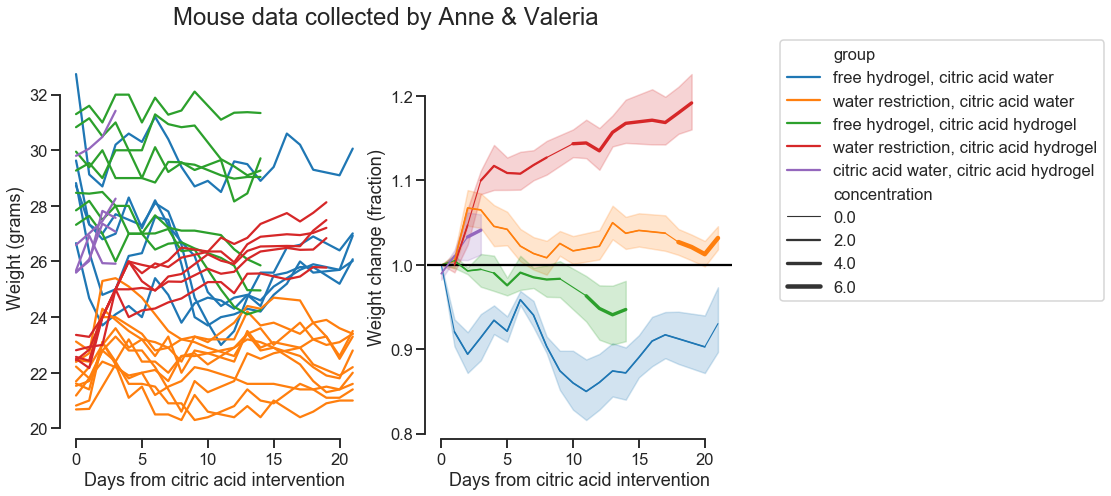

In [10]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(1,2, sharex=True, figsize=(12, 7))
sns.lineplot(x="days", y="weight", hue="group", 
                  estimator=None, units="mouse", data=data, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days from citric acid intervention")
ax[0].legend_.remove()

# same, but with weight as % from baseline
sns.lineplot(x="days", y="weight_change", hue="group", size=0, data=data, ax=ax[1], legend=False)
plt.axhline(y=1,color="black")
sns.lineplot(x="days", y="weight_change", hue="group", size="concentration", data=data, ax=ax[1], ci=None) # overlay the concentration in thickness
ax[1].set(ylabel="Weight change (fraction)", xlabel="Days from citric acid intervention")
ax[1].legend(loc='center right', bbox_to_anchor=(2.25, 0.7), ncol=1) # move box outside
sns.despine(offset=2, trim=True)
f.suptitle("Mouse data collected by Anne & Valeria", fontsize=24)

In [50]:
# PART 2: ANUP'S RAT DATA
worksheet = doc.worksheet("Rats")
data_rat = pd.DataFrame(worksheet.get_all_records())
data_rat.drop([''], axis=1, inplace=True) # get rid of extra stuff
data_rat["rat"] = "LC40"

data_rat['weight'] = pd.to_numeric(data_rat['weight'], errors='coerce') # force all values into floats
data_rat.dropna(subset=['weight'], inplace=True)
data['concentration'] = pd.to_numeric(data['concentration'], errors='coerce') # force all values into floats
data_rat = data_rat.groupby(['rat']).apply(pct_change)
data_rat['ntrials'] = pd.to_numeric(data_rat['ntrials'], errors='coerce') # force all values into floats

# # make the date relative to baseline (1st entry)
data_rat['date'] = pd.to_datetime(data_rat.date)
data_rat['days'] = data_rat.date - data_rat.date[0] # convert to number of days from start of the experiment
data_rat['days'] = data_rat.days.dt.days 

# average weight, concentration and trial count for all baseline days
data_rat_baseline   = data_rat.loc[data_rat['concentration'] == 0, ['weight', 'weight_change', 'ntrials', 'concentration', 'days']].mean().to_frame().transpose()
data_rat_baseline['days'][0] = data_rat.loc[data_rat['concentration'] == 0, ['days']].max()
data_rat_citricacid = data_rat.loc[data_rat['concentration'] > 0, ['weight', 'weight_change', 'ntrials', 'concentration', 'days']]

# concatenate back
data_rat = pd.concat([data_rat_baseline, data_rat_citricacid], ignore_index=True)
data_rat['days'] = data_rat.days - data_rat.days[0] # reset dates

data_rat.head(n=10)


,weight,weight_change,ntrials,concentration,days
0,316.4,1.000000,1466.2,0,0.0
1,333.0,1.052465,NaN,2,1.0
2,342.0,1.080910,NaN,2,2.0
3,348.0,1.099874,938.0,2,3.0
4,352.0,1.112516,847.0,2,4.0
5,357.0,1.128319,893.0,2,5.0
6,363.0,1.147282,591.0,2,6.0
7,369.0,1.166245,NaN,2,7.0


Text(0.5,0.98,'Rat LC40, collected by Anup')

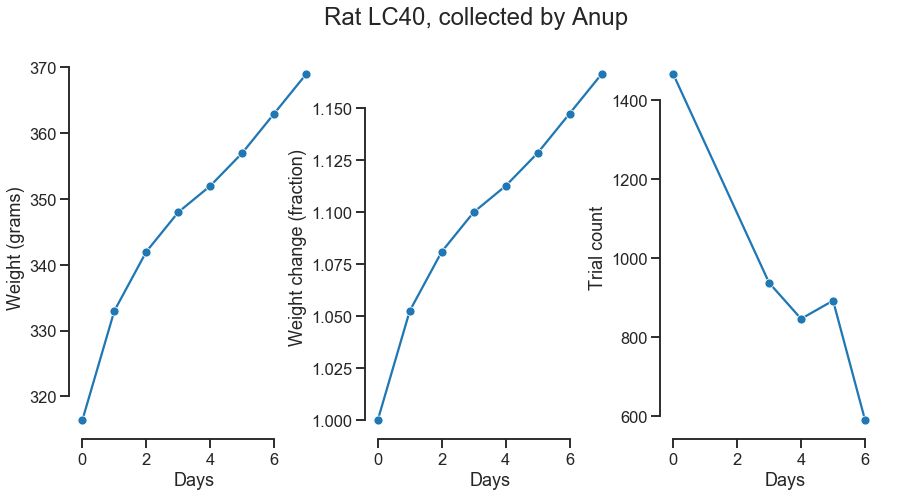

In [6]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(1,3, sharex=True, figsize=(15, 7))
sns.lineplot(x="days", y="weight", marker="o", data=data_rat, ax=ax[0], legend=False)
ax[0].set(ylabel="Weight (grams)", xlabel="Days")

# same, but with weight as % from baseline
sns.lineplot(x="days", y="weight_change", marker="o", data=data_rat, ax=ax[1], legend=False)
ax[1].set(ylabel="Weight change (fraction)", xlabel="Days")

# trial count
sns.lineplot(x="days", y="ntrials", marker="o", data=data_rat, ax=ax[2], legend=False)
ax[2].set(ylabel="Trial count", xlabel="Days")

sns.despine(offset=2, trim=True)
f.suptitle("Rat LC40, collected by Anup", fontsize=24)